In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
import itertools

## 1. Transform the time series

In [2]:
# Import data
time_series = pd.read_csv('timeseries.csv')
time_series.head()

,week,year,date,total_revenue
0,49,2009,01/12/2009,232177.51
1,50,2009,07/12/2009,207908.73
2,51,2009,14/12/2009,207685.87
3,52,2009,21/12/2009,35731.90
4,1,2010,04/01/2010,167636.95


In [3]:
# Process data and set the column date to be index
time_series = time_series[['date', 'total_revenue']]
time_series['date'] = pd.to_datetime(time_series['date'], dayfirst=True)
time_series = time_series.set_index('date')
time_series

,total_revenue
date,
2009-12-01,232177.51
2009-12-07,207908.73
2009-12-14,207685.87
2009-12-21,35731.90
2010-01-04,167636.95
...,...
2011-11-07,263717.33
2011-11-14,276216.98
2011-11-21,248234.58


In [4]:
# Convert the data to be monthly
monthly_series = time_series['total_revenue'].resample('M').sum()
monthly_series.head()

C:\Users\thanh\AppData\Local\Temp\ipykernel_22056\1442508401.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = time_series['total_revenue'].resample('M').sum()


date
2009-12-31    683504.010
2010-01-31    555802.672
2010-02-28    504558.956
2010-03-31    725625.131
2010-04-30    575677.512
Freq: ME, Name: total_revenue, dtype: float64

<Axes: title={'center': 'Total revenue by month'}, xlabel='Month', ylabel='Total revenue'>

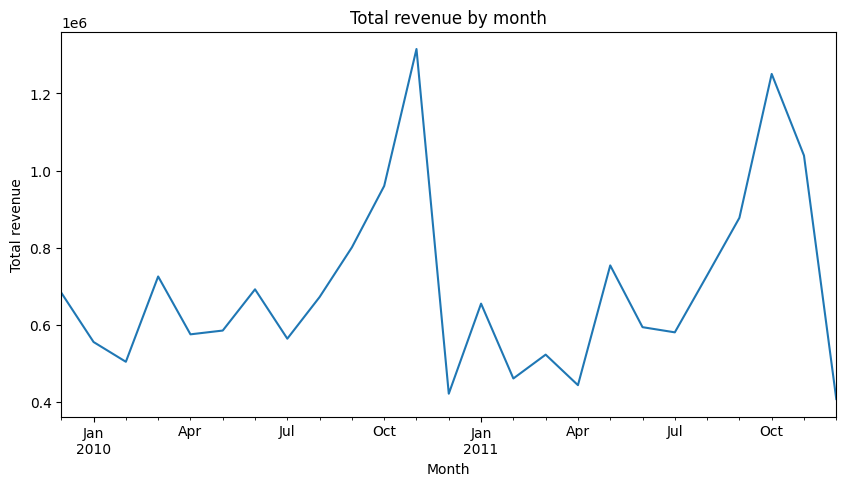

In [5]:
# Plot the monthly data
monthly_series.plot(title='Total revenue by month', figsize=(10, 5), xlabel='Month', ylabel='Total revenue')

## 2. Time series decomposition

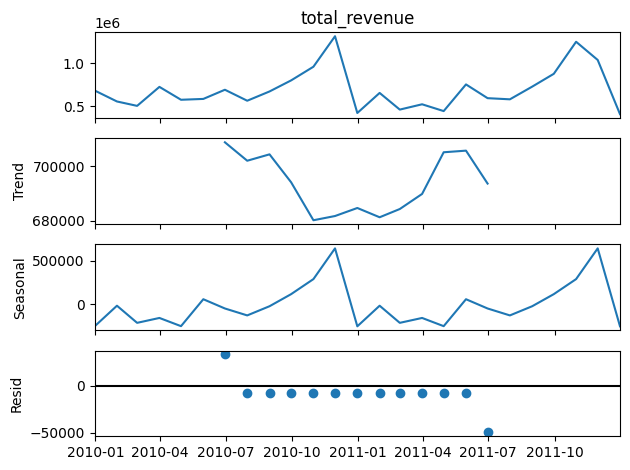

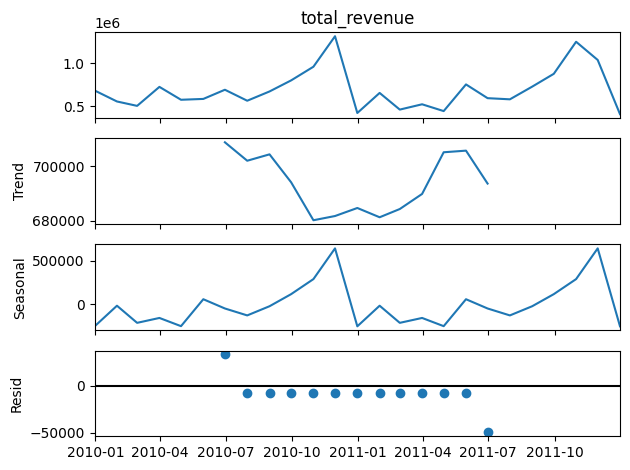

In [6]:
# Get the time series components
components = sm.tsa.seasonal_decompose(x=monthly_series)
components.plot()

In [7]:
# Detail of each component
trend = components.trend
print(trend.head())

seasonality = components.seasonal
print(seasonality.head())

remainder = components.resid
print(remainder.head())

date
2009-12-31   NaN
2010-01-31   NaN
2010-02-28   NaN
2010-03-31   NaN
2010-04-30   NaN
Freq: ME, Name: trend, dtype: float64
date
2009-12-31   -254693.649139
2010-01-31    -17835.907931
2010-02-28   -214813.899222
2010-03-31   -158558.121347
2010-04-30   -252955.190806
Freq: ME, Name: seasonal, dtype: float64
date
2009-12-31   NaN
2010-01-31   NaN
2010-02-28   NaN
2010-03-31   NaN
2010-04-30   NaN
Freq: ME, Name: resid, dtype: float64


## 3. Stationary, AR(p) and MA(q) testing

<Axes: title={'center': 'Montly revenue with 12-month rolling mean and standard deviation'}, xlabel='date', ylabel='Revenue'>

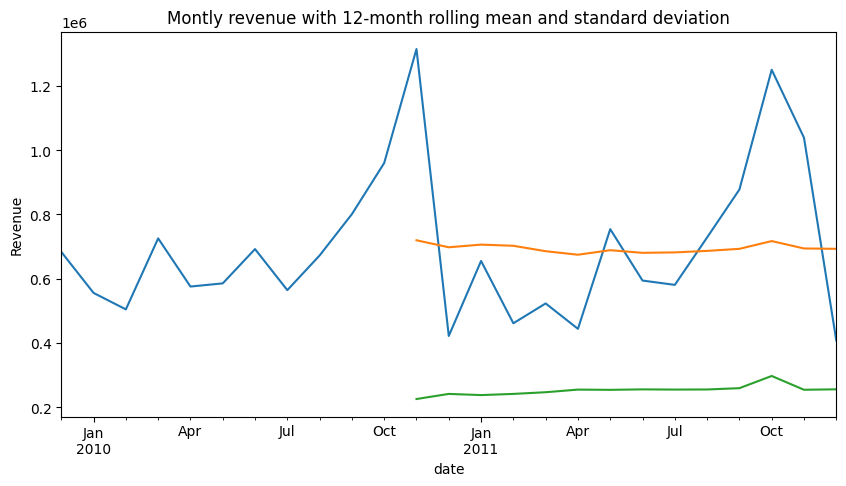

In [8]:
# Check the stationarity of the time series by statistical measures
monthly_series.plot(title='Montly revenue with 12-month rolling mean and standard deviation', figsize=(10, 5), xlabel='Month', ylabel='Revenue')
monthly_series.rolling(window=12).mean().plot()
monthly_series.rolling(window=12).std().plot()

In [9]:
# Check the stationarity of the time series by Augmented Dickey-Fuller test
ad_fuller_test = sm.tsa.stattools.adfuller(x=monthly_series, autolag='AIC')
print('Augmented Dickey-Fuller test statistic:', ad_fuller_test[0])

Augmented Dickey-Fuller test statistic: -3.6538709279115507


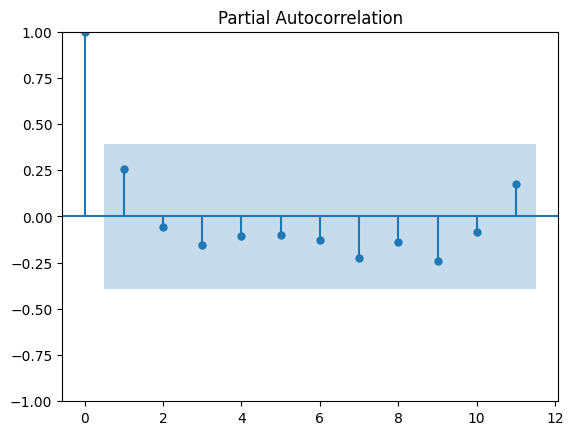

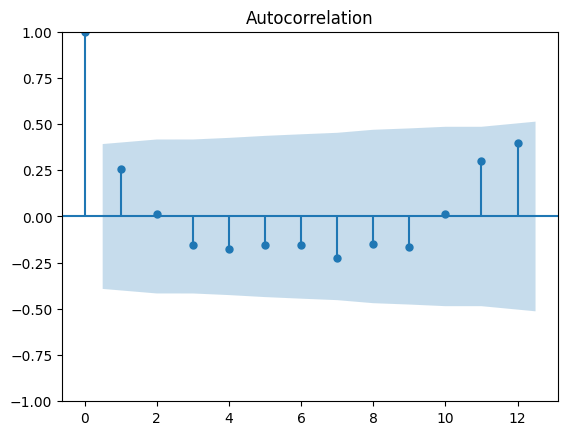

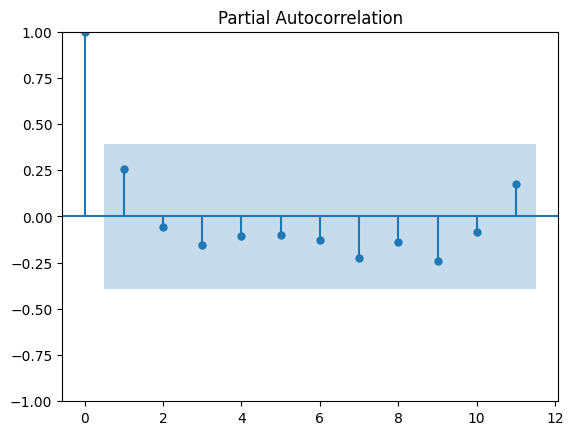

In [10]:
# Check AR(p) and MA(q) by ACF and PACF tests
plot_acf(monthly_series)
plot_pacf(monthly_series, lags=11)

## 4. Fit the data to MA, AR, ARMA and ARIMA models

In [11]:
# Fit data to MA model
model_ma = sm.tsa.statespace.SARIMAX(monthly_series, order=(0, 0, 1))
results_ma = model_ma.fit()
print(f'''AIC of MA(1) model: {results_ma.aic}''')

AIC of MA(1) model: 735.7906414433098


C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [12]:
# Fit data to AR model
model_ar = sm.tsa.statespace.SARIMAX(monthly_series, order=(1, 0, 0))
results_ra = model_ar.fit()
print(f'''AIC of AR(1) model: {results_ra.aic}''')

AIC of AR(1) model: 703.4620739015511


In [13]:
# Fit data to ARMA model
model_arma = sm.tsa.statespace.SARIMAX(monthly_series, order=(1, 0, 1))
results_arma = model_arma.fit()
print(f'''AIC of ARMA(1, 1) model: {results_arma.aic}''')

AIC of ARMA(1, 1) model: 702.1603952405223


In [14]:
# Fit data to ARIMA model
model_arima = sm.tsa.statespace.SARIMAX(monthly_series, order=(1, 1, 1))
results_arima = model_arima.fit()
print(f'''AIC of ARMA(1, 1) model: {results_arima.aic}''')

AIC of ARMA(1, 1) model: 672.0261771707892


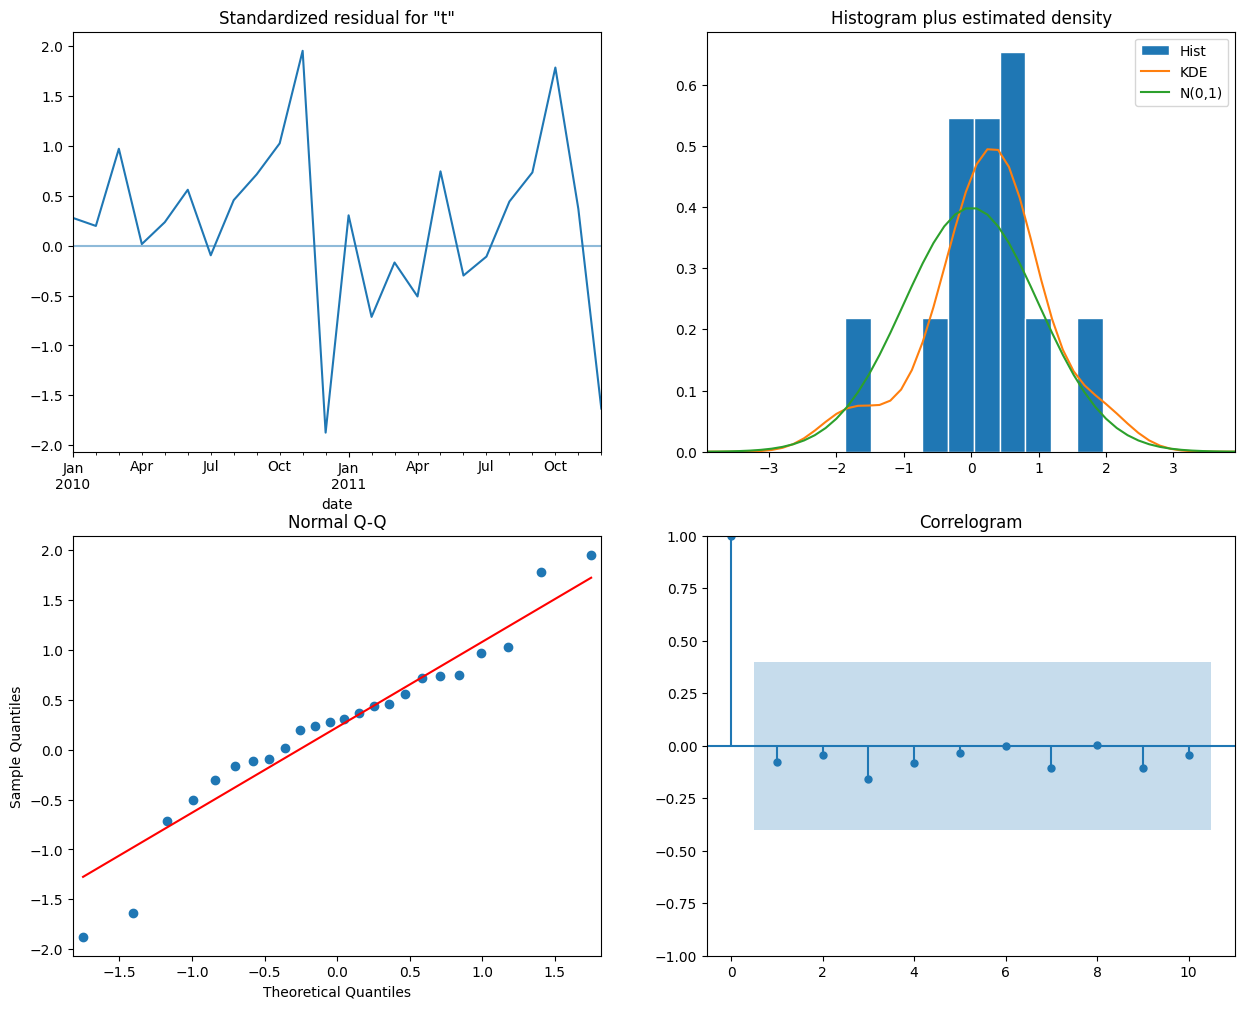

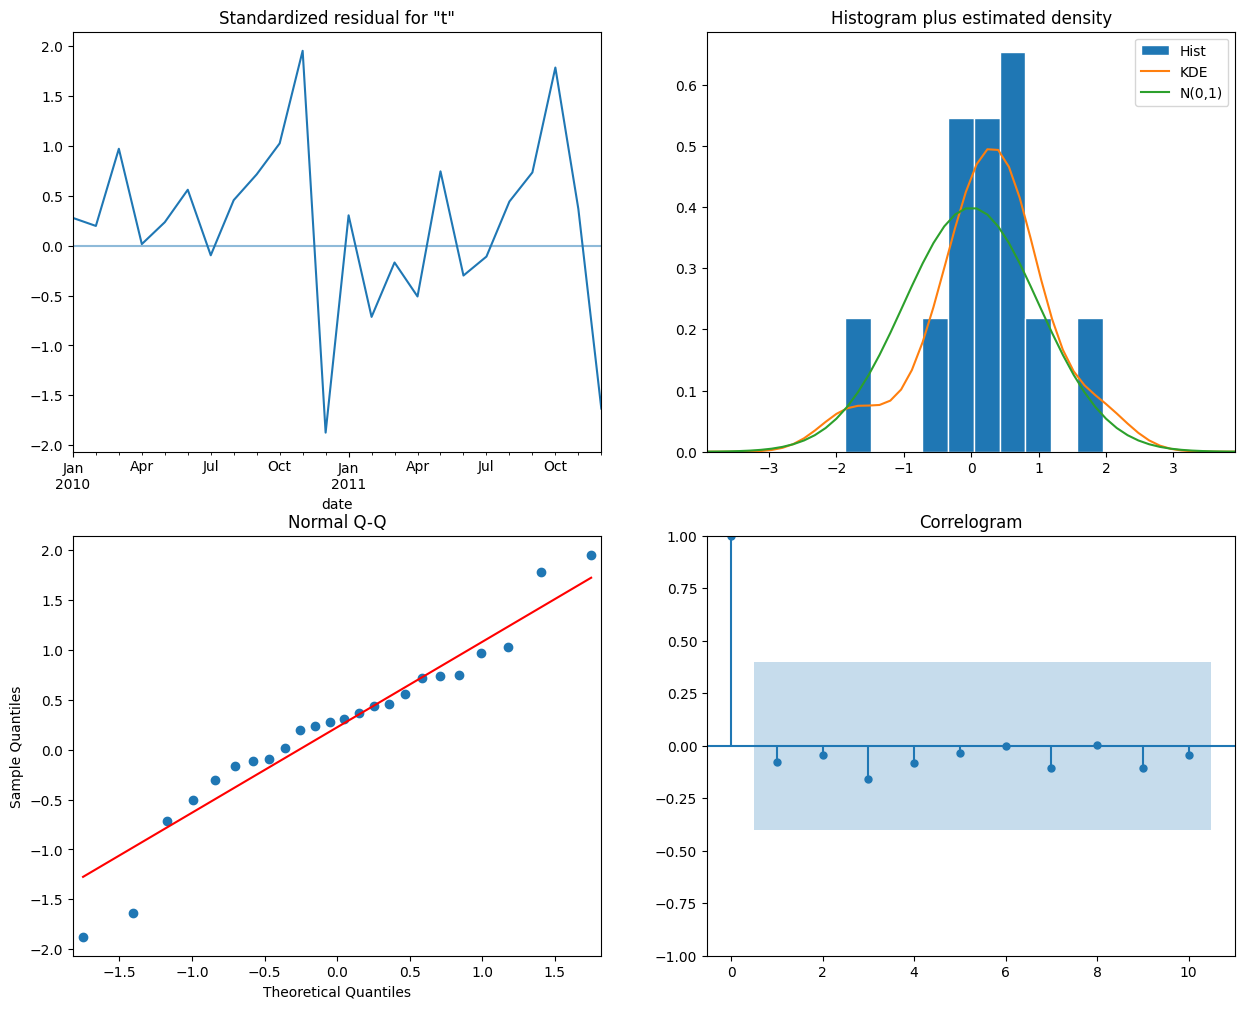

In [15]:
# Plot the ARIMA model
results_arima.plot_diagnostics(figsize=(15, 12))

## 5. ARIMA best parameters

In [16]:
# Create a grid of ARIMA parameters
P = D = Q = p = d = q = range(0, 3)
S = 12    
           
# Create a list of all combinations of p, d, q, P, D, Q
combinations = list(itertools.product(p, d, q, P, D, Q))
arima_orders = [(x[0], x[1], x[2]) for x in combinations]
seasonal_orders = [(x[3], x[4], x[5], S) for x in combinations]
results_data = pd.DataFrame(columns=['p', 'd', 'q', 'P', 'D', 'Q', 'AIC'])

In [17]:
# Loop through the combinations and fit the ARIMA model
for i in range(len(combinations)):
     try:
          model = sm.tsa.statespace.SARIMAX(monthly_series,
                                            order=arima_orders[i],
                                            seasonal_order=seasonal_orders[i]
                                            )
          result= model.fit()
          results_data.loc[i,'p'] = arima_orders[i][0]
          results_data.loc[i,'d'] = arima_orders[i][1]
          results_data.loc[i,'q'] = arima_orders[i][2]
          results_data.loc[i,'P'] = seasonal_orders[i][0]
          results_data.loc[i,'D'] = seasonal_orders[i][1]
          results_data.loc[i,'Q'] = seasonal_orders[i][2]
          results_data.loc[i,'AIC'] = result.aic
     except:
          continue

# SHow the best results
results_data[results_data.AIC == min(results_data.AIC)]
    

C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to e

,p,d,q,P,D,Q,AIC
87,0,1,0,0,2,0,2.0
168,0,2,0,0,2,0,2.0


 ## 6. Forecast using best ARIMA model and measure errors

MAE: 292655.52


C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


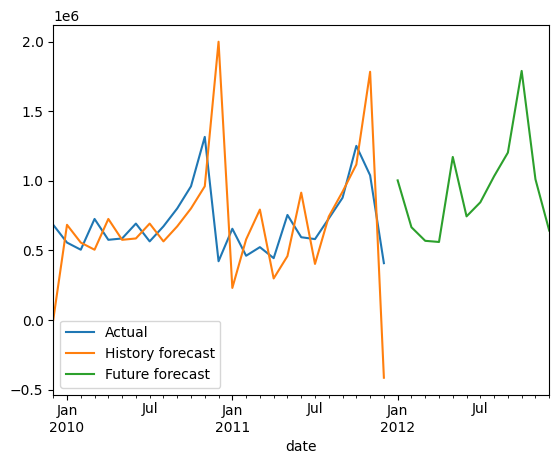

In [18]:
# Pick the best model
best_model_1 = sm.tsa.statespace.SARIMAX(monthly_series, 
                                       order = (0, 1, 0), 
                                       seasonal_order = (0, 2, 0, 12))
results = best_model_1.fit()

# Forecast the history using fitted model
history = results.get_prediction(start='2009-12-31')

# Forecast the future using the fitted model
forecast = results.get_forecast(steps=12)

# Result
history_mean = history.predicted_mean
forecast_mean = forecast.predicted_mean

# Plot the result
monthly_series.plot(label='Actual')
history_mean.plot(label='History forecast')
forecast_mean.plot(label='Future forecast')
plt.legend()

# MAE
mae = abs(monthly_series-history_mean).mean()
print(f'MAE: {mae:.2f}')

## 7. Exponential smoothing

In [19]:
# Create different Exponential Smoothing models 
model_expo1 = ExponentialSmoothing(monthly_series, trend='add', seasonal='add', seasonal_periods=12)
model_expo2 = ExponentialSmoothing(monthly_series, trend='add', seasonal='mul', seasonal_periods=12)
model_expo3 = ExponentialSmoothing(monthly_series, trend='mul', seasonal='add', seasonal_periods=12)
model_expo4 = ExponentialSmoothing(monthly_series, trend='mul', seasonal='mul', seasonal_periods=12)

# Fit the data into models
resuls_1 = model_expo1.fit()
resuls_2 = model_expo2.fit()
resuls_3 = model_expo3.fit()
resuls_4 = model_expo4.fit()

C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: Convergen

In [20]:
# Result of model 1
resuls_1.summary()

Dep. Variable:,total_revenue,No. Observations:,25
Model:,ExponentialSmoothing,SSE,348055194398.472
Optimized:,True,AIC,615.919
Trend:,Additive,BIC,635.421
Seasonal:,Additive,AICC,729.919
Seasonal Periods:,12,Date:,"Wed, 21 May 2025"
Box-Cox:,False,Time:,12:32:37
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0403571,alpha,True
smoothing_trend,0.0403571,beta,True


In [21]:
# Result of model 2
resuls_2.summary()

Dep. Variable:,total_revenue,No. Observations:,25
Model:,ExponentialSmoothing,SSE,348455512867.790
Optimized:,True,AIC,615.948
Trend:,Additive,BIC,635.450
Seasonal:,Multiplicative,AICC,729.948
Seasonal Periods:,12,Date:,"Wed, 21 May 2025"
Box-Cox:,False,Time:,12:32:37
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0050000,alpha,True
smoothing_trend,0.0050000,beta,True


In [22]:
# Result of model 3
resuls_3.summary()

Dep. Variable:,total_revenue,No. Observations:,25
Model:,ExponentialSmoothing,SSE,347736714481.927
Optimized:,True,AIC,615.896
Trend:,Multiplicative,BIC,635.398
Seasonal:,Additive,AICC,729.896
Seasonal Periods:,12,Date:,"Wed, 21 May 2025"
Box-Cox:,False,Time:,12:32:37
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0403571,alpha,True
smoothing_trend,0.0403571,beta,True


In [23]:
# Result of model 4
resuls_4.summary()

Dep. Variable:,total_revenue,No. Observations:,25
Model:,ExponentialSmoothing,SSE,347424178432.151
Optimized:,True,AIC,615.873
Trend:,Multiplicative,BIC,635.375
Seasonal:,Multiplicative,AICC,729.873
Seasonal Periods:,12,Date:,"Wed, 21 May 2025"
Box-Cox:,False,Time:,12:32:37
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0050000,alpha,True
smoothing_trend,0.0050000,beta,True


In [24]:
# Predict the future using the fitted models
fit_1 = model_expo1.fit().predict(0, len(monthly_series))
fit_2 = model_expo2.fit().predict(0, len(monthly_series))
fit_3 = model_expo3.fit().predict(0, len(monthly_series))
fit_4 = model_expo4.fit().predict(0, len(monthly_series))

C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: Convergen

In [25]:
# MAE result of each model
mae1 = abs(monthly_series - fit_1).mean()
mae2 = abs(monthly_series - fit_2).mean()
mae3 = abs(monthly_series - fit_3).mean()
mae4 = abs(monthly_series - fit_4).mean()

print(f' MAE_1: {mae1}')
print(f' MAE_2: {mae2}')
print(f' MAE_3: {mae3}')
print(f' MAE_4: {mae4}')

 MAE_1: 74666.10370999467
 MAE_2: 76933.20717007219
 MAE_3: 74628.74031726114
 MAE_4: 76549.20149779976


C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


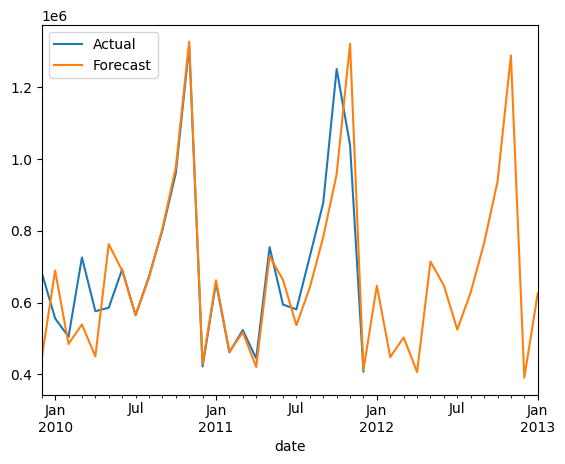

In [26]:
# Using the best model to forecast the future
forecast = model_expo3.fit().predict(0, len(monthly_series)+12)

# Plot the result
monthly_series.plot(label='Actual')
forecast.plot(label='Forecast')
plt.legend()